# SC/BEP Data Insights

In [1]:
import pathlib
import pandas as pd
import geopandas as gpd
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter("ignore")

## Forewords

### Disclaimer

 > Data insights provided in this notebook are not validated and may certainly contain errors. They are shared for feedback only with no warranty or liability of any kind.



### Sources

 - ULB/Faculty, Faculty mission: anonymized administrative forms (CSV);
 - ULB/DTAS/BEP, Travel Types Carbon Coefficient (Excel);
 - ArgGIS Hub, Country of the World (GeoJSON);
 - OSM, Nominatim Geocoding API (JSON);
 
### Methodology

 - Add index to mission records;
 - Permute reversed timestamps;
 - First cleansing of city names;
 - Split multiple destinations (origin is assumed to be unique): mission becomes travel;
 - Expand destinations;
 - Second cleansing of all city names;
 - Fill missing origin using Brussels as default;
 - Manually correct about 100 mispelled cities;
 - Geocode cleansed city names;
 - Add index to travel records;
 - Building geometries with Coordinate Reference System EPSG:4326;
 - Computing Geodesic Distance in km between geometries using WGS-84 ellipsoid as reference;

### To do

 - Fill missing travel types and merge with carbon coefficients;
 - Assess magnitude of different errors affecting distance and time to see where most of the effort should be spent;
 - Sequence travel with multiple destinations instead of considering as multiple distinct travels;
 - Do we double distance as agent must return (how do we know if it has already returned?);
 - Precisly define how long mission are handled;
 - Precisly define how mission with multiple destination are handled;
 - Check long distance around 18000 km are relevant (eg. Australia: has Vincity algorithm converged?);
 - Find Flight Distance table if any available;
 - How do we fill travel type when information lacks (distance criterion?);
 - Compute insightful metrics such as distance/elasped
 - Does PHILA stand for PHILO (typo)? 
 

## Load datasets

In [3]:
country = gpd.read_file(pathlib.Path("data/country.geojson").open().read())

In [4]:
travels = pd.read_excel('data/travels.xlsx')

In [5]:
travels.columns

Index(['travel_id', 'mission_id', 'from_geocodeid', 'from_citycleansed',
       'from_ISO2', 'from_city', 'from_lat', 'from_lon', 'from_accuracy',
       'from_confidence', 'to_geocodeid', 'to_citycleansed', 'to_ISO2',
       'to_city', 'to_lat', 'to_lon', 'to_accuracy', 'to_confidence', 'start',
       'stop', 'travel_type', 'acronym', 'faculty', 'elapsed', 'distance'],
      dtype='object')

### Aggregate Travels to Missions

In [6]:
missions = travels.groupby('mission_id').agg({
    'mission_id': 'first', 'acronym': 'first', 'faculty': 'first',
    'start': 'first', 'stop':'first', 'elapsed': 'first', 'travel_type': 'first',
    'from_ISO2': 'first', 'to_ISO2': list, 'distance': 'sum',
})
missions['speed'] = missions['distance']/(24*missions['elapsed'])
missions['year'] = missions['start'].dt.year
missions['travel_type'] = missions['travel_type'].fillna('unknown')
missions

,mission_id,acronym,faculty,start,stop,elapsed,travel_type,from_ISO2,to_ISO2,distance,speed,year
mission_id,,,,,,,,,,,,
0,0,DECA,LTC,2010-05-28,2010-06-01,5,unknown,BE,"[GB, GB, BE]",810.745964,6.756216,2010
1,1,SIC,LTC,2010-06-22,2010-07-08,17,unknown,BE,"[GB, BE]",645.698894,1.582595,2010
2,2,SIC,LTC,2010-06-22,2010-07-08,17,unknown,BE,"[GB, BE]",645.698894,1.582595,2010
3,3,SIC,LTC,2010-07-12,2010-07-17,6,unknown,BE,"[GB, BE]",645.698894,4.484020,2010
4,4,SIC,LTC,2010-05-31,2010-06-01,2,unknown,BE,"[FR, BE]",528.587028,11.012230,2010
...,...,...,...,...,...,...,...,...,...,...,...,...
6125,6125,DECS,SBS,2020-02-20,2020-02-20,1,train,BE,"[GB, BE]",645.698894,26.904121,2020
6126,6126,DECS,SBS,2020-02-23,2020-02-28,6,train,BE,"[FR, FR, FR, BE]",1923.612609,13.358421,2020
6127,6127,L&L,LTC,2020-02-16,2020-02-18,3,train,BE,"[FR, BE]",1536.399657,21.338884,2020


In [7]:
missions = missions.loc[missions['elapsed']<31,:]

In [8]:
missions[['elapsed', 'distance', 'speed']].describe()

,elapsed,distance,speed
count,5813.000000,5813.000000,5813.000000
mean,5.330810,3666.315897,31.467337
std,5.059264,5699.319236,65.444968
min,1.000000,0.000000,0.000000
25%,2.000000,528.587028,7.906664
50%,4.000000,1204.759456,14.962521
75%,7.000000,3164.852448,28.953931
max,30.000000,39186.535851,1388.485110


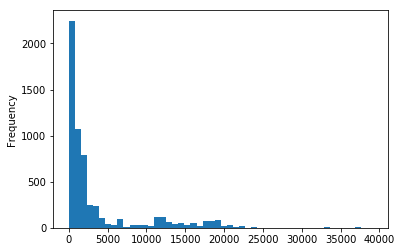

In [9]:
missions['distance'].plot(kind='hist', bins=50)

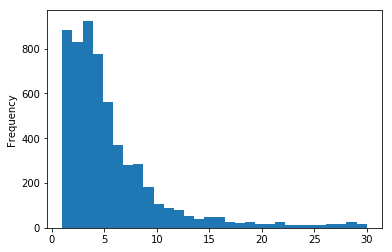

In [10]:
missions['elapsed'].plot(kind='hist', bins=30)

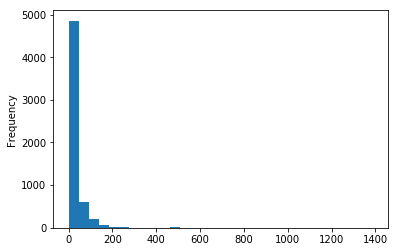

In [11]:
missions['speed'].plot(kind='hist', bins=30)

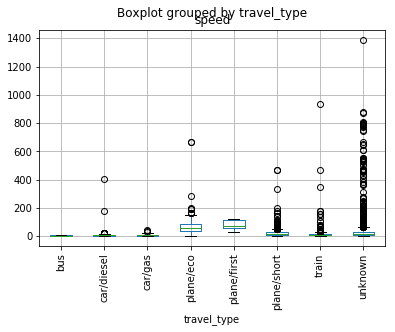

In [12]:
axe = missions.boxplot(column='speed', by='travel_type', rot=90)

(0, 200)

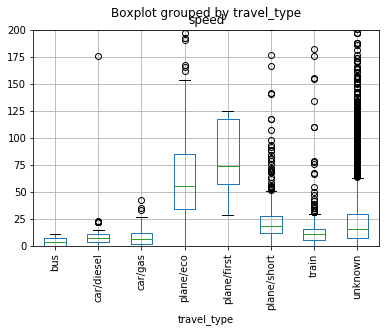

In [13]:
axe = missions.boxplot(column='speed', by='travel_type', rot=90)
axe.set_ylim([0 ,200])

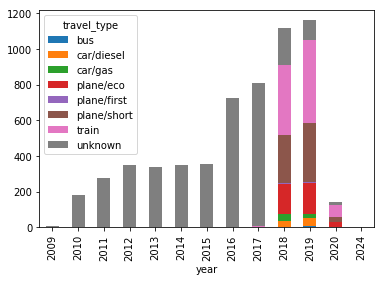

In [14]:
mc = missions.groupby(['year', 'travel_type'])['mission_id'].count().unstack()
axe = mc.plot(kind='bar', stacked=True)

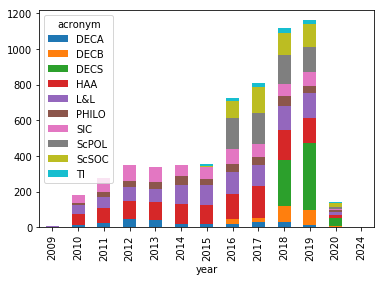

In [15]:
mc = missions.groupby(['year', 'acronym'])['mission_id'].count().unstack()
axe = mc.plot(kind='bar', stacked=True)

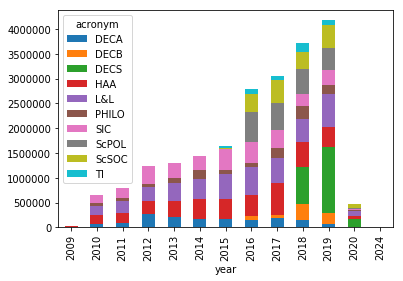

In [16]:
mc = missions.groupby(['year', 'acronym'])['distance'].sum().unstack()
axe = mc.plot(kind='bar', stacked=True)

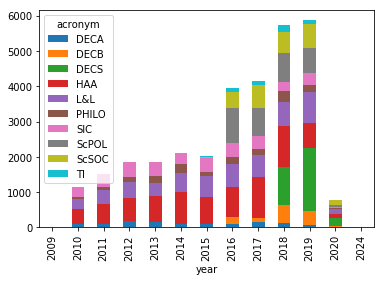

In [17]:
mc = missions.groupby(['year', 'acronym'])['elapsed'].sum().unstack()
axe = mc.plot(kind='bar', stacked=True)

In [18]:
#sns.kdeplot(missions['distance'], missions['elapsed'])